In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('DATASET.csv')
df.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46.391133804,entry_to_shop,successful,8531.0
1,12446736,6391574,762832,2,Android,2024-11-30 16:26:16.875713965,order_paid,successful,8531.0
2,90232698,6391574,762832,2,Android,2024-11-30 16:50:44.827088753,order_finished,successful,8531.0
3,74183469,9246026,762832,2,Android,2024-11-29 13:21:28.729203894,reload_the_page,NaN,6186.0
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35.213637901,entry_to_shop,NaN,6186.0


# Data Cleaning & EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326921 entries, 0 to 326920
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id            326921 non-null  int64  
 1   session_id          326921 non-null  int64  
 2   user_id             326921 non-null  int64  
 3   variation           326921 non-null  int64  
 4   platform            326921 non-null  object 
 5   datetime_event      326921 non-null  object 
 6   event_type          326921 non-null  object 
 7   final_order_status  170632 non-null  object 
 8   shop_id             315842 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 22.4+ MB


In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
event_id,326921.0,NaN,NaN,NaN,54971223.274348,26005727.141926,10000027.0,32451323.0,54919061.0,77504919.0,99999925.0
session_id,326921.0,NaN,NaN,NaN,5493266.772453,2598273.9833,1000058.0,3246170.0,5486265.0,7742072.0,9999979.0
user_id,326921.0,NaN,NaN,NaN,550159.16329,259722.459324,100003.0,325736.0,549509.0,775308.0,999985.0
variation,326921.0,NaN,NaN,NaN,1.349684,0.476871,1.0,1.0,1.0,2.0,2.0
platform,326921,2,Android,225929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
datetime_event,326921,324699,2024-11-29 23:59:24.000000000,674,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_type,326921,4,entry_to_shop,168215,NaN,NaN,NaN,NaN,NaN,NaN,NaN
final_order_status,170632,3,successful,146035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shop_id,315842.0,NaN,NaN,NaN,5440.652238,2645.409437,1003.0,3150.0,5351.0,7801.0,9992.0


### **Summary Statistics**

**Mean of 1.35** - Variation 1 (control) has 65% of the data. (65%/35%) split between control and test isn't exactly even - was this intentional or a randomization error? 

Most events 69% occured on **Android devices** - why such a skew to one device? Will need to keep this platform imbalance in mind. 

In [5]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_values


event_id                   0
session_id                 0
user_id                    0
variation                  0
platform                   0
datetime_event             0
event_type                 0
final_order_status    156289
shop_id                11079
dtype: int64

In [6]:
missing_percentage

event_id               0.000000
session_id             0.000000
user_id                0.000000
variation              0.000000
platform               0.000000
datetime_event         0.000000
event_type             0.000000
final_order_status    47.806351
shop_id                3.388892
dtype: float64

### **Missing Values**

Almost half of the events don't have a **final_order_status** - need to check if any order completion events are missing their status

**shop_id** is missing for some events - could be a data completeness issue. 

Missing final_order_status by event_type (%):
 event_type
reload_the_page    75.166141
entry_to_shop      68.838689
order_finished      0.000000
order_paid          0.000000
Name: final_order_status, dtype: float64

Order events missing status: 0

Missing shop_id by event_type (%):
 event_type
reload_the_page    20.566178
entry_to_shop       0.000000
order_finished      0.000000
order_paid          0.000000
Name: shop_id, dtype: float64

Missing shop_id by platform (%):
 platform
Android    3.434265
iOS        3.287389
Name: shop_id, dtype: float64

Missing shop_id by variation (%):
 variation
1    3.416713
2    3.337153
Name: shop_id, dtype: float64


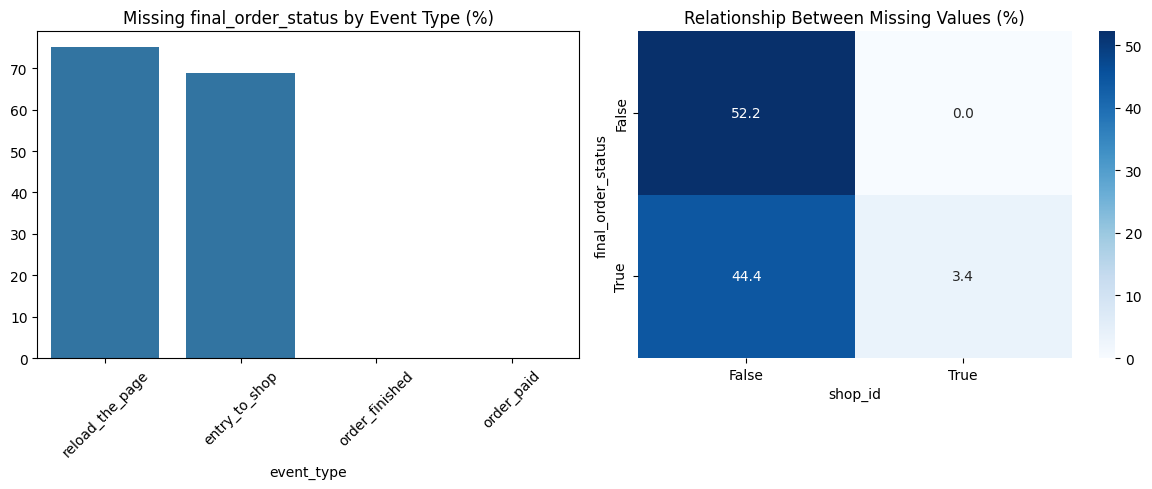

In [ ]:
# Missing final_order_status by event_type
missing_by_event = df.groupby('event_type')['final_order_status'].apply(lambda x: x.isnull().mean() * 100).sort_values(ascending=False)
print("Missing final_order_status by event_type (%):\n", missing_by_event)

# Check if order completion events are missing status
order_missing = df[df['event_type'].isin(['order_paid', 'order_finished']) & df['final_order_status'].isnull()]
print(f"\nOrder events missing status: {len(order_missing)}")

# Missing shop_id analysis
print("\nMissing shop_id by event_type (%):\n", df.groupby('event_type')['shop_id'].apply(lambda x: x.isnull().mean() * 100).sort_values(ascending=False))
print("\nMissing shop_id by platform (%):\n", df.groupby('platform')['shop_id'].apply(lambda x: x.isnull().mean() * 100))
print("\nMissing shop_id by variation (%):\n", df.groupby('variation')['shop_id'].apply(lambda x: x.isnull().mean() * 100))

# Visualize relationship between missing values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=missing_by_event.index, y=missing_by_event.values)
plt.title('Missing final_order_status by Event Type (%)')
plt.xticks(rotation=45)

plt.show()

**For missing final_order_status**: This pattern makes  sense from a business perspective - early funnel events like page reloads and shop entries naturally don't have order statuses. 
It's not random and follows a structure - we will leave them as is. 

**For missing shop_id**: About 20.6% of reload_the_page events have missing shop IDs. All other event types have complete shop ID information. We could fill in the missing shop_ids based on users with mulitple events from the same session - this could deal with some of them. 

However, since the reload_page events is the only event with missing shop ids, is relatively small across platforms and variations we could just keep it as is.
The similar rates of missing values of shop_ids is a good thing:

- Android (3.43%) and iOS (3.29%)
- Variation 1 (3.42%) and Variation 2 (3.34%) 

We can test for significance here - but these tiny differences here are minute (0.14% between platforms and 0.08% between variations) and would have a negligible impact on the AB test results even if they were significant. With more time I would check this. Let's soldier on! and focus on other part of the analysis

### **Detect Outliers - Session Duration**

abnormal user behaviour

### **Timestamps**

### **Create relevant KPIs**